### Object Classification using GluonCV

We'll walk through the process of using a pre-trained model for object detection using GluonCV. 

#### 1) Import
We'll start by preparing our input image for the object-detection network. We'll need to import MXNet, GluonCV and Pyplot.

In [22]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt

#### 2) Download the Test Image
We will use the following image for object detection
![dog](https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg)

The image have a few obvious objects. In the foreground, we have a dog that's just in front of a bike. And in the background, we have a tree and a car. We'd like a model to detect these objects. So let's download this image from the url.

In [23]:
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_path = 'dog.jpg'
gcv.utils.download(url=image_url, path=image_path)

100%|██████████| 160/160 [00:00<00:00, 3443.37KB/s]


'dog.jpg'

#### 4) Load the Image

So let's load the image using imread(). 

data type:  <class 'numpy.uint8'>
shape:  (576, 768, 3)
type:  <class 'mxnet.ndarray.ndarray.NDArray'>


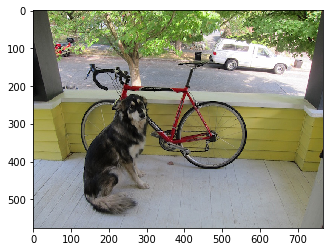

In [27]:
image = mx.image.imread(image_path)
print('data type: ', image.dtype)
print('shape: ', image.shape)
print('type: ', type(image))
plt.imshow(image.asnumpy())
plt.show()

#### 5) Transform the Image
As seen above, the image have a data layout of HWC. Our image has a height of 576 pixels with a width of 768 pixels. And it's a colored image with three channels. So let's transform our image into the required format.

CV provides a function that applies all of the necessary preprocessing steps for the yolo network. We call yolo.transform_test with our image and also provide the short length of the output image with the short parameter. Our input mage was landscape where the height is smaller than the width.
Using this function, the height will be resized to 512 pixels while maintaining the aspect ratio of the image.

In [28]:
image, chw_image = gcv.data.transforms.presets.yolo.transform_test(image, short=512)

print('data type: ', image.dtype)
print('shape: ', image.shape)
print('minimum value: ', image.min().asscalar())
print('maximum value: ', image.max().asscalar())

data type:  <class 'numpy.float32'>
shape:  (1, 3, 512, 683)
minimum value:  -2.117904
maximum value:  2.64


You'll notice that the transform test function returns two objects. Our first object is the transformed image that is ready to be given to the network. Our second object is just a resized version of the image, and we use this image for plotting our results.

Well firstly, it's been resized. It's also a batch of one image. It's in NCHW format instead of NHWC format. And it's an array of 32-bit floats instead of 8-bit integers. And finally, it's normalized using the image net 1K statistics.
We can plot the CHW image because it's in the CHW format that is used by pipeline.

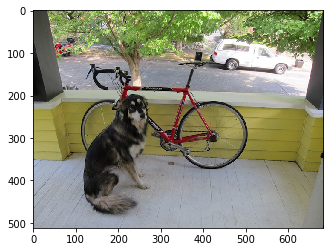

In [29]:
plt.imshow(chw_image)

You can see the effect of the resize. Our short edge is now 512 pixels instead of 576 while the width remains one-third times longer than the height.

#### 6) Load Pretrained Model
We can use the get_model function to load our pretrained model from the CV model zoo. 

**Don't forget to set the pretrained argument to true.**

We'll use the yolo3 network with a darknet53 backbone that has been trained on the coco dataset.

In [30]:
network = gcv.model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

100%|██████████| 224190/224190 [00:04<00:00, 51121.55KB/s]


#### 7) Make Prediction
You can call network just like a function once again. Give network and image and a prediction will be returned.
When using detection models, you can expect three MXNet ndarrays to be returned. We can loop through the tuple and print out the shape of these arrays.

1. The first array contains the object class indexes. 
2. The second array contains the object class probabilities. 
3. The last array contains the object bounding box coordinates. 

In [34]:
prediction = network(image)
print('type: ', type(prediction))

for index, array in enumerate(prediction):
    print('# {} shape : {}'.format(index+1, array.shape))

type:  <class 'tuple'>
# 1 shape : (1, 100, 1)
# 2 shape : (1, 100, 1)
# 3 shape : (1, 100, 4)


Notice how the shape of each of these arrays starts with a 1, 100. Why is this?

And our model can predict up to 100 objects in a single image.

So for the first array, with a shape of 1, 100, 1, we have 1 image, 100 potential objects, and 1 class index per object. 

And for the last array, with shape 1, 100, 4, we have 1 image, 100 potential objects. And 4 values for each object to define its bounding box.

Since we're only performing object detection on one image, let's remove the additional batch dimension for all of the arrays. We can then go ahead and unpack the tuple and give each array its own variable. 

In [35]:
prediction = [array[0] for array in prediction]
class_indices, probabilities, bounding_boxes = prediction

#### 8) Object Class

Let's take a closer look at the object class indexes. We saw the class indexes before. Let's extract the top-k class.

Although our model can potentially detect 100 objects per image, let's just take a look at the class indexes for the first ten objects. 

In [37]:
k = 10
print(class_indices[:k])


[[16.]
 [ 1.]
 [ 7.]
 [ 2.]
 [13.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
<NDArray 10x1 @cpu(0)>


Our first detected object has a predicted class of 16, and we see more objects with classes 1, 7, 2, 13 and 0. After this, we have a number of objects with a class index of -1. 

-1 is a special class index that is used to indicate there is no detected object. 

We have six detected objects in total, with the remaining 94 potential objects being padded with -1 values.

Now let's look up the class labels using the classes' property of the network. 

A top object was class 16. Using this list, we can see that dog has been detected in the image, just as we were expecting.

In [39]:
network.classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

#### 9) Object Probabilities
It's the same as for object class indexes, but instead of the object class index, we have the associated object class probability. We can interpret this as our confidence that the class index is correct.

In [40]:
print(probabilities)


[[ 0.9919528 ]
 [ 0.9600399 ]
 [ 0.62269694]
 [ 0.29241997]
 [ 0.01795173]
 [ 0.01141722]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.    

Using a confidence threshold of 50%, we can see that three objects have been detected. You'll want to experiment with the threshold for your own application. You can lower the threshold to get more objects but you're likely to see more detection errors.

Our model is very confident in two of its detections, with probability scores in the high 90s.

These could be the two foreground objects.

You'll see -1 again. We don't have a confidence score for padded objects.

#### 10) Bounding Box Coordinate
You'll notice there are four values used to define the bounding box of each object. We specify the coordinates for the top-left corner, and the bottom-right corner of the bounding box, giving us four values in total.

In [42]:
print(bounding_boxes)


[[116.53647  201.33235  281.90323  482.09094 ]
 [ 93.92975  107.73944  504.75128  375.75415 ]
 [416.78833   69.800644 615.01794  148.89009 ]
 [416.78833   69.800644 615.01794  148.89009 ]
 [ 90.88356  125.878815 504.4449   402.7955  ]
 [532.78235   91.84185  547.3104   104.69111 ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.      

#### 10) Visualization
It's hard to interpret the bounding boxes from a table. So let's jump straight into a visualization.

CV comes with a bounding box plot function out of the box.

We can provide the resized image (*chw_image*) from earlier. And also each of the network outputs.

Optionally, we can provide the class labels to add annotations to our plot.


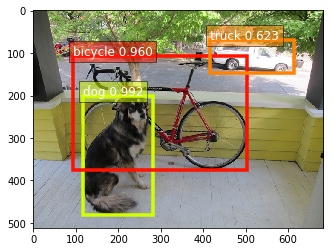

In [43]:
gcv.utils.viz.plot_bbox(chw_image, bounding_boxes, probabilities, class_indices, class_names=network.classes)

We can see that our network has done a good job of detecting the objects. We have detected a dog, a bike and a truck. Our network missed the tree in the background. But that's because we're using a model that's been pretrained on coco. And coco doesn't have an object class for trees.

In conclusion, we started by preprocessing the input image. We then loaded an object detection model from the model Zoo and used it to generate a prediction. And finally, we interpreted the network outputs and visualized the detected object